In [1]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use(plt.style.available[24])
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import Ridge as cpu_Ridge
from sklearn.preprocessing import PolynomialFeatures
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the xtick labels
plt.rc('ytick', labelsize=12)     # fontsize of the ytick labels (also applies to colorbar)
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title
plt.rc('lines', linewidth=2)     # line width
plt.rc('figure', figsize=(6, 5)) # figure size
plt.rc('axes', axisbelow=True)
import sys
sys.path.append('../datasets')
sys.path.append('..')
from fuchs_model import calc_laser_energy
from helpful_functions import *

In [2]:
num_inputs = 4
num_outputs = 3 # Must have 4:3 function for this optimization to work
noise_level = 30 # Train on 10% noise
degree = 7

input_list = ['Intensity', 'Target Thickness', 'Focal Distance', 'Contrast'] # independent variables
output_list = ['Max Proton Energy', 'Total Proton Energy', 'Avg Proton Energy']
identifier = 'threeEns'

train_df = pd.read_hdf(f'../datasets/fuchs_v5_0_seed-2_train_1525000_noise_{noise_level}_threeEns_.h5', key='df').fillna(0)

datype = np.float32

# Define X, y as arrays
X = np.array(train_df[input_list],dtype=datype)
y = np.array(train_df[output_list],dtype=datype)
num_pts_tot = X.shape[0]

X_train, y_train, X_val, y_val, input_transformer, output_transformer = make_poly_datasets(X, y, random_state=42)

In [3]:
poly = PolynomialFeatures(degree=degree)
ridge = cpu_Ridge(alpha=1e-3)
model = make_pipeline(poly, ridge)
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=7)),
                ('ridge', Ridge(alpha=0.001))])

In [4]:
correction_factors = np.mean(output_transformer.inverse_transform(y_train) / output_transformer.inverse_transform(model.predict(X_train)), axis=0)
outputs_true = output_transformer.inverse_transform(y_val)
outputs_pred = output_transformer.inverse_transform(model.predict(X_val))
print(f'correction factors: ', correction_factors)
print(f'MAPE with original outputs: ', mape(outputs_true, outputs_pred, multioutput='raw_values')*100)
print(f'MAPE with corrected outputs: ', mape(outputs_true, outputs_pred * correction_factors, multioutput='raw_values')*100)

correction factors:  [1.0694283 1.1400809 1.0612882]
MAPE with original outputs:  [30.695408 46.334816 28.805511]
MAPE with corrected outputs:  [33.30895  54.36679  30.957302]


In [5]:
thickness_min = 0.5 
thickness_max = 5 
thickness_grid_pts = 46 
focal_distance_min = 0
focal_distance_max = 30
focal_distance_grid_pts = 301
thicknesses_range = np.linspace(thickness_min, thickness_max, thickness_grid_pts)
focal_distances_range = np.linspace(focal_distance_min, focal_distance_max, focal_distance_grid_pts)
Xgrid, Ygrid = np.meshgrid(thicknesses_range, focal_distances_range)
thicknesses = Xgrid.flatten()
focal_distances = Ygrid.flatten()
intensities = np.full_like(thicknesses, 1e19)
contrasts = np.full_like(thicknesses, 1e-7)
Xgen = np.vstack((intensities, thicknesses, focal_distances, contrasts)).T
Xgenscaled = input_transformer.transform(Xgen)
ygen = output_transformer.inverse_transform(model.predict(Xgenscaled)) * correction_factors

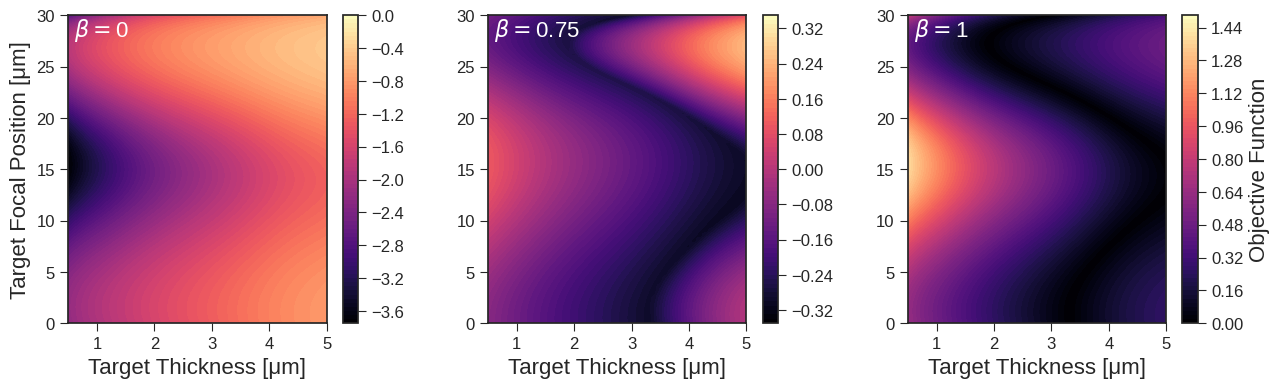

In [8]:
desired_cutoff = 1
betas_all = [0, 0.25, 0.5, 0.75, 1]
betas = [0, 3, 4]
def obj(x, y, desired_cutoff_energy=1, beta = 0):
    cutoff_energy = y[:, 0]
    total_energy = y[:, 1]
    laser_energy_mev = calc_laser_energy(x[:, 0] * 1e4, 1.5e-6, 40e-15) / (1.609e-13) # Convert to MeV
    conversion_efficiency = total_energy / laser_energy_mev * 100
    return beta * np.abs(cutoff_energy - desired_cutoff_energy) + (1 - beta) * (-conversion_efficiency)

OBJs = [obj(Xgen, ygen, beta = beta, desired_cutoff_energy = desired_cutoff).reshape(focal_distance_grid_pts, thickness_grid_pts) for beta in betas_all]

fig, ax = plt.subplots(figsize=(5*len(betas), 4), ncols = len(betas))
cax1 = ax[0].contourf(Xgrid, Ygrid, OBJs[betas[0]], cmap='magma', levels=np.linspace(-3.75, 0, 76))
cax2 = ax[1].contourf(Xgrid, Ygrid, OBJs[betas[1]], cmap='magma', levels=np.linspace(-0.35*(desired_cutoff-.5)*2, 0.35*(desired_cutoff-.5)*2, 71))
cax3 = ax[2].contourf(Xgrid, Ygrid, OBJs[betas[2]], cmap='magma', levels=np.linspace(0, 1.5, 76))

for i in range(3):
    ax[i].set_ylim(0, 30)
    ax[i].set_xlabel('Target Thickness [μm]')
    ax[i].text(0.6, 28, r'$\beta = $' + str(betas_all[betas[i]]), fontsize=16, color='white')
    
ax[0].set_ylabel('Target Focal Position [μm]')

cbar1 = fig.colorbar(cax1)
cbar2 = fig.colorbar(cax2)
cbar3 = fig.colorbar(cax3)
#cbar1.set_label('Objective Function')
#cbar2.set_label('Objective Function')
cbar3.set_label('Objective Function')
fig.subplots_adjust(wspace=0.3)

In [9]:
np.save('results/Xgrid.npy', Xgrid)
np.save('results/Ygrid.npy', Ygrid)
for i, beta in enumerate(betas_all):
    np.save(f'results/POLY_beta={beta}_cutoff={desired_cutoff}.npy', OBJs[i])